NAG参数： [[ -2.29586749e-01   2.01756882e+00   2.98820399e+00   3.42576932e+00
    3.57175068e+00   2.91265332e+00   1.64832247e+00   1.99009701e+00
    1.86252224e+00   1.72445642e+00   1.23289773e+00   5.20040839e-05
    2.45155289e-03   2.32490979e+00   2.70253537e+00   2.75903090e+00
    2.57350408e+00   2.75931844e+00   1.17383650e+00   2.15917903e+00
    4.23913388e-01   2.00239987e+00   1.06474301e+00   1.24134462e+00
    1.29419076e+00   2.20201998e-01   2.40923785e-01   3.02224278e-01
    1.22718511e+00   6.19653676e-02   3.96935150e-01   1.17395792e+00
    1.61013773e-01   2.23667046e-03   1.72101085e+00   2.00239987e+00
    2.15917903e+00   2.53308382e+00   4.63236788e+00   6.27655912e+00
    2.44205919e+00   2.32860023e+00   6.44924961e-01   9.36270172e-01
    3.71061066e-01   1.22406072e-01   8.06127059e-01   3.20394023e-01
   -1.07730854e+00   6.18466012e-01   1.43146879e+00   1.61179965e+00
   -4.09507673e+00  -7.68545531e-01   8.59169281e-01  -2.87780571e+00
   -2.2472665

<IPython.core.display.Javascript object>


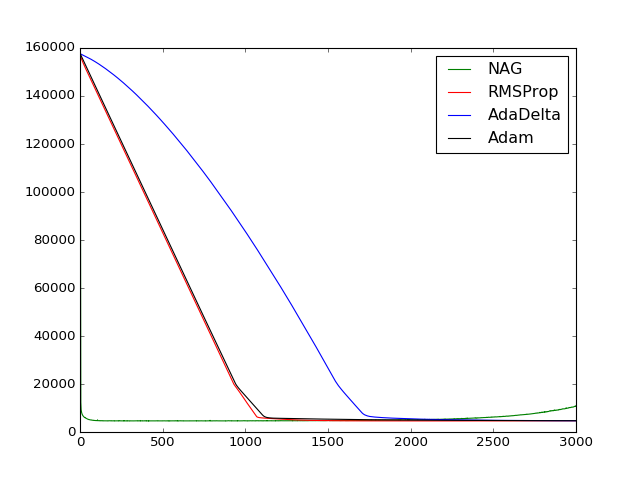

In [1]:
%matplotlib notebook
from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import math
import random

filename = "C:\\Users\\admin\\Desktop\\Jupyter\\a9a.txt"
x_train, y_train = load_svmlight_file(filename, n_features=123)
filename = "C:\\Users\\admin\\Desktop\\Jupyter\\a9a.t.txt"
x_test, y_test = load_svmlight_file(filename, n_features=123)


x_train,x_test=x_train.toarray(),x_test.toarray()
y_train, y_test = y_train.reshape((-1,1)), y_test.reshape((-1,1))
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test=np.hstack([x_test, np.ones((x_test.shape[0], 1))])
m,n=np.shape(x_train)  #32561 124 最后一列为1
p,q=np.shape(x_test)   #16281 124 最后一列为1




paramNAG = np.ones((1, n))
paramRMSProp = np.ones((1, n))
paramAdaDelta = np.ones((1, n))
paramAdam= np.ones((1, n))

learning_rate = 0.001
num_iter = 3000
#NAG 参数
Gamma=0.001
pre_grad=np.zeros((1, n))
#RMSProp 参数
GtRMSProp=np.zeros((1,n))
#AdaDelta 参数
GtAdaDelta=np.zeros((1,n))
deltaParam=np.zeros((1,n))
deltaT=np.zeros((1,n))
#Adam 参数
GtAdam=np.zeros((1,n))
Mt=np.zeros((1,n))


lossTestNAG = np.zeros((1, num_iter))
lossTestRMSProp = np.zeros((1, num_iter))
lossTestAdaDelta = np.zeros((1, num_iter))
lossTestAdam = np.zeros((1, num_iter))


for k in range(num_iter):
    grad = np.zeros((1, n))
    y_train_predict = x_train.dot(paramNAG.T)
    y_test_predict = x_test.dot(paramNAG.T)
    # NAG(Nesterov accelerated gradient):
    # 第0次迭代 无先前梯度 直接随机梯度下降
    if k == 0:
        for l in range(500):
            i = random.randint(0, m - 1)
            for j in range(n):
                if y_train[i, 0] * y_train_predict[i, 0] < 1:
                    grad[0, j] += -1 * y_train[i, 0] * x_train[i, j]
        # 计算C*sum(-x*y）
        grad[0] *= 0.8
        # 计算w-C*sum(x*y)
        for j in range(n):
            grad[0, j] += abs(paramNAG[0, j])
        # 更新梯度 param=param-learning_rate * grad
        paramNAG[0] -= learning_rate * grad[0]
        # 记录第0次梯度
        pre_grad=grad.copy()
    # 除了第0次迭代后 均为先根据之前的梯度更新param后再计算梯度 之后再根据目前梯度*学习率+先前梯度*Gamma更新参数
    if k != 0:
        # 先利用先前梯度*Gamma更新出新的参数再计算出新的梯度
        paramNew = paramNAG.copy()
        for i in range(n):
            paramNew[0, i] = paramNew[0, i] - (pre_grad[0, i] * Gamma)
        y_train_predict = x_train.dot(paramNew.T)
        # 利用新的参数算出新的梯度
        for l in range(500):
            i = random.randint(0, m - 1)
            for j in range(n):
                if y_train[i, 0] * y_train_predict[i, 0] < 1:
                    grad[0, j] += -1 * y_train[i, 0] * x_train[i, j]
        grad[0] *= 0.8
        for j in range(n):
            grad[0, j] += abs(paramNAG[0, j])
        # 根据新的梯度*学习率+先前梯度*Gamma更新参数
        paramNAG[0] = paramNAG[0]-learning_rate * grad[0]-Gamma*pre_grad[0]
        # 记录本次梯度 用于下次迭代更新参数
        pre_grad = grad.copy()


    # print("第", k, "次迭代：")
    # print("参数：")
    # print(param)

    loss_test = 0
    # loss = C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    # 计算sum(max(0, 1-w*x*y))
    for i in range(x_test.shape[0]):
        if y_test[i, 0] * y_test_predict[i, 0] < 1:
            loss_test = loss_test + 1 - y_test[i, 0] * y_test_predict[i, 0]
    # 计算 C*sum(max(0, 1-w*x*y))
    loss_test *= 0.8
    # 计算 C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    lossTestNAG[0, k] = loss_test + 0.5 * paramNAG.dot(paramNAG.T)
    # print("NAG验证误差：", lossTestNAG)

for k in range(num_iter):
    grad = np.zeros((1, n))
    y_train_predict = x_train.dot(paramRMSProp.T)
    y_test_predict = x_test.dot(paramRMSProp.T)
    # RMSProp：
    # 每次使用100组数组随机梯度下降
    # 利用Gt计算学习率
    for l in range(500):
        i = random.randint(0, m - 1)
        for j in range(n):
            if y_train[i, 0] * y_train_predict[i, 0] < 1:
                grad[0, j] += -1 * y_train[i, 0] * x_train[i, j]
    # 计算C*sum(-x*y）
    grad[0] *= 0.8
    # 计算w-C*sum(x*y)
    for j in range(n):
        grad[0, j] += abs(paramRMSProp[0, j])
    #计算Gt=0.9 * Gt + 0.1 * grad * grad
    GtRMSProp[0] = 0.9 * GtRMSProp[0] + 0.1 * grad[0] * grad[0]
    # 更新梯度 param=param- n/sqrt(Gt+e) * grad
    paramRMSProp[0] -= (0.001 / (np.sqrt(GtRMSProp[0]+0.00000001))) * grad[0]

    # print("第", k, "次迭代：")
    # print("参数：")
    # print(param)

    loss_test = 0
    # loss = C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    # 计算sum(max(0, 1-w*x*y))
    for i in range(x_test.shape[0]):
        if y_test[i, 0] * y_test_predict[i, 0] < 1:
            loss_test = loss_test + 1 - y_test[i, 0] * y_test_predict[i, 0]
    # 计算 C*sum(max(0, 1-w*x*y))
    loss_test *= 0.8
    # 计算 C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    lossTestRMSProp[0, k] = loss_test + 0.5 * paramRMSProp.dot(paramRMSProp.T)
    # print("验证误差：", lossTestRMSProp)

for k in range(num_iter):
    grad = np.zeros((1, n))
    y_train_predict = x_train.dot(paramAdaDelta.T)
    y_test_predict = x_test.dot(paramAdaDelta.T)
    # AdaDelta：
    # 每次使用100组数组随机梯度下降
    # 利用Gt和deltaT计算学习率
    for l in range(500):
        i = random.randint(0, m - 1)
        for j in range(n):
            if y_train[i, 0] * y_train_predict[i, 0] < 1:
                grad[0, j] += -1 * y_train[i, 0] * x_train[i, j]
    # 计算C*sum(-x*y）
    grad[0] *= 0.8
    # 计算w-C*sum(x*y)
    for j in range(n):
        grad[0, j] += abs(paramAdaDelta[0, j])

    #计算Gt=0.9 * Gt + 0.1 * grad * grad
    GtAdaDelta[0] = 0.9 * GtAdaDelta[0] + 0.1 * grad[0] * grad[0]
    # 计算 deltaParam=-1*sqrt(deltaT+0.00000001)/sqrt(Gt+0.00000001) * grad
    deltaParam[0] = -1 * (np.sqrt(deltaT[0]+0.00000001) / np.sqrt(GtAdaDelta[0]+0.00000001)) * grad[0]
    # 更新梯度 param=param+deltaParam
    paramAdaDelta[0] += deltaParam[0]
    # 计算deltaT
    deltaT[0]=0.95 * deltaT[0] + 0.05 * deltaParam * deltaParam


    loss_test = 0
    # loss = C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    # 计算sum(max(0, 1-w*x*y))
    for i in range(x_test.shape[0]):
        if y_test[i, 0] * y_test_predict[i, 0] < 1:
            loss_test = loss_test + 1 - y_test[i, 0] * y_test_predict[i, 0]
    # 计算 C*sum(max(0, 1-w*x*y))
    loss_test *= 0.8
    # 计算 C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    lossTestAdaDelta[0, k] = loss_test + 0.5 * paramAdaDelta.dot(paramAdaDelta.T)
    # print("验证误差：", lossTestAdaDelta)

for k in range(num_iter):
    grad = np.zeros((1, n))
    y_train_predict = x_train.dot(paramAdam.T)
    y_test_predict = x_test.dot(paramAdam.T)

    #Adam:
    for l in range(500):
        i = random.randint(0, m - 1)
        for j in range(n):
            if y_train[i, 0] * y_train_predict[i, 0] < 1:
                grad[0, j] += -1 * y_train[i, 0] * x_train[i, j]
    # 计算C*sum(-x*y）
    grad[0] *= 0.8
    # 计算w-C*sum(x*y)
    for j in range(n):
        grad[0, j] += abs(paramAdam[0, j])

    #计算Mt=0.9 * Mt + 0.1 * grad
    Mt[0] = 0.9 * Mt[0] + 0.1 * grad[0]
    #计算Gt=0.999 * Gt + 0.001 * grad * grad
    GtAdam[0] = 0.999 * GtAdam[0] + 0.001 * grad[0] * grad[0]
    # 计算 alpha= n * sqrt(1-0.999^t) / 1-0.9^t
    alpha = 0.001 * math.sqrt(1-pow(0.999,k+1)) / (1-pow(0.9,k+1))
    # 更新参数 param=param - alpha * Mt / sqrt(Gt+e)
    paramAdam[0] -= alpha * Mt[0] / np.sqrt(GtAdam[0]+0.00000001)



    # print("第", k, "次迭代：")
    # print("参数：")
    # print(param)

    loss_test = 0
    # loss = C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    # 计算sum(max(0, 1-w*x*y))
    for i in range(x_test.shape[0]):
        if y_test[i, 0] * y_test_predict[i, 0] < 1:
            loss_test = loss_test + 1 - y_test[i, 0] * y_test_predict[i, 0]
    # 计算 C*sum(max(0, 1-w*x*y))
    loss_test *= 0.8
    # 计算 C*sum(max(0, 1-w*x*y)) + 0.5*||w||*||w||
    lossTestAdam[0, k] = loss_test + 0.5 * paramAdam.dot(paramAdam.T)
    # print("验证误差：", lossTestAdam)


print("NAG参数：",paramNAG)
print("RMS参数：",paramRMSProp)
print("paramAdaDelta参数：",paramAdaDelta)
print("paramAdam参数：",paramAdam)
x=np.arange( 1,num_iter+1,1)
plt.plot(x,lossTestNAG[0],'green',label='NAG')
plt.plot(x,lossTestRMSProp[0],'red',label='RMSProp')
plt.plot(x,lossTestAdaDelta[0],'blue',label='AdaDelta')
plt.plot(x,lossTestAdam[0],'black',label='Adam')
plt.legend(loc='upper right')
plt.show()









